<a href="https://colab.research.google.com/github/ZongoSosthene/PROJET_DDEFI_2025/blob/main/TD_not%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<u><h1 style='text-align: center;'>Travaux Dirigés Notés – 3A_DDEFI</h1></u>
<h2 style='text-align: center;'>Prédiction des Prix et Actifs du S&P 500 grâce à du Machine Learning simple</h2>

## 12/2024

<h1 style='color: blue;'>Partie 1 : Collecte et Préparation des Données</h1>

### <u>1 - Collecte des données</u>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [ ]:
# Récupérer les données sur 5 ans
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="5y")

vix = yf.Ticker("^VIX")
vix_data = vix.history(period="5y")

taux = yf.Ticker("^IRX")
taux_data = taux.history(period="5y")

In [ ]:
# Réindexer les données pour ne garder que les dates
sp500_data.index = sp500_data.index.date
vix_data.index = vix_data.index.date
taux_data.index = taux_data.index.date

In [ ]:
# Fusionner les datasets sur l'index
merged_data = pd.concat([sp500_data['Close'], vix_data['Close'], taux_data['Close']], axis=1)

# Renommer les colonnes
merged_data.columns = ['SP500_Close', 'VIX_Close', 'Taux_Close']

### <u>2 - Pré-traitement des données</u>

In [ ]:
# Gestion des valeurs manquantes (extrapolation ou suppression)
merged_data = merged_data.dropna()

# Vérifier les résultats
print(merged_data)

            SP500_Close  VIX_Close  Taux_Close
2019-12-31  3230.780029  13.780000       1.505
2020-01-02  3257.850098  12.470000       1.495
2020-01-03  3234.850098  14.020000       1.473
2020-01-06  3246.280029  13.850000       1.488
2020-01-07  3237.179932  13.790000       1.500
...                 ...        ...         ...
2024-12-23  5974.069824  16.780001       4.215
2024-12-24  6040.040039  14.270000       4.200
2024-12-26  6037.589844  14.730000       4.215
2024-12-27  5970.839844  15.950000       4.178
2024-12-30  5906.939941  17.400000       4.182

[1258 rows x 3 columns]


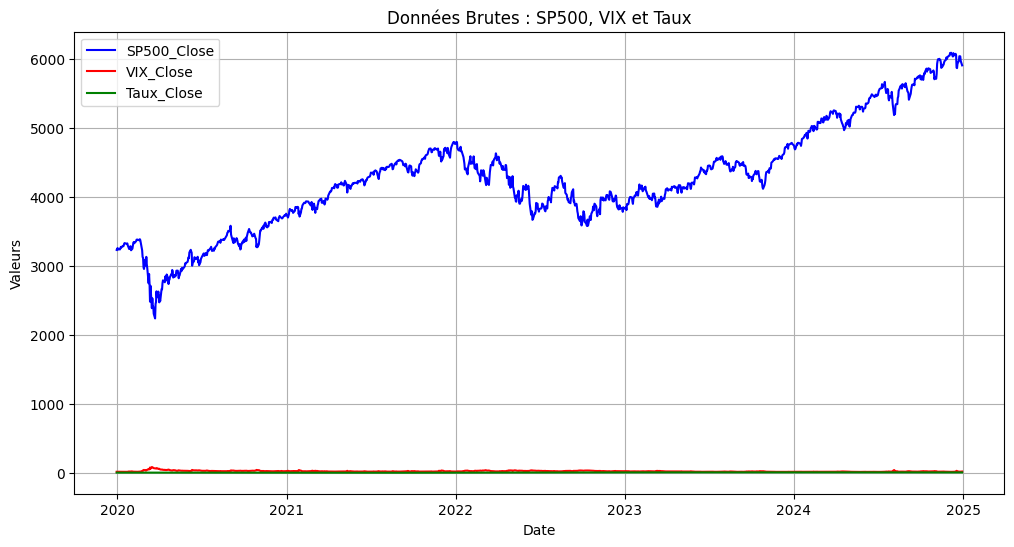

In [ ]:
# Graphe
columns_to_plot = ['SP500_Close', 'VIX_Close', 'Taux_Close']
plt.figure(figsize=(12, 6))
for col, color in zip(columns_to_plot, ['blue', 'red', 'green']):
    plt.plot(merged_data.index, merged_data[col], label=col, color=color)

plt.title("Données Brutes : SP500, VIX et Taux")
plt.xlabel("Date")
plt.ylabel("Valeurs")
plt.legend()  # Affiche la légende pour identifier les séries
plt.grid(True)  # Optionnel : pour améliorer la lisibilité
plt.show()

#### --- Calcul des rendements logarithmiques ---

In [ ]:
# Calcul des rendements log pour chaque colonne
log_returns = np.log(merged_data / merged_data.shift(1))

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### --- Analyse de stationnarité ---

--- Test ADF pour SP500_Close ---
Statistique ADF : -10.614255380360452
p-value : 5.728774219486648e-19
Valeurs critiques : {'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}
Conclusion : La série est stationnaire (p-value ≤ 0.05)
--- Test ADF pour VIX_Close ---
Statistique ADF : -19.76096199287907
p-value : 0.0
Valeurs critiques : {'1%': -3.4355796466416777, '5%': -2.863849421064024, '10%': -2.5679995625056926}
Conclusion : La série est stationnaire (p-value ≤ 0.05)
--- Test ADF pour Taux_Close ---
Statistique ADF : -11.762080449621699
p-value : 1.1416557702577138e-21
Valeurs critiques : {'1%': -3.435621806786881, '5%': -2.8638680226791444, '10%': -2.5680094689100477}
Conclusion : La série est stationnaire (p-value ≤ 0.05)


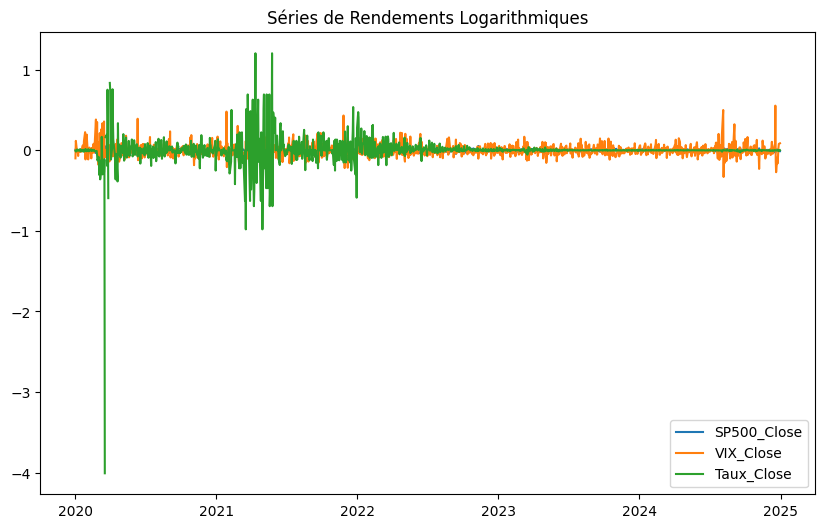

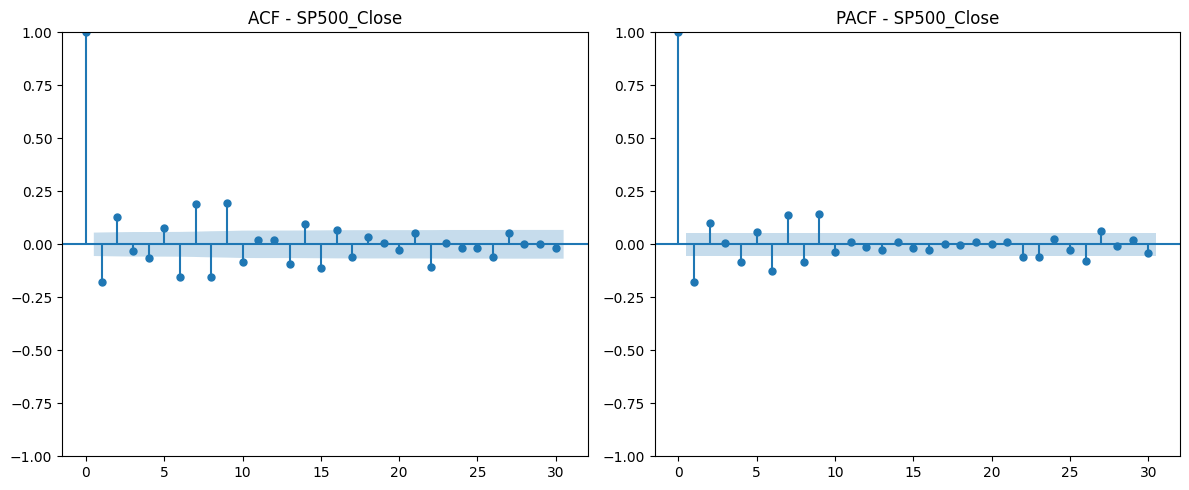

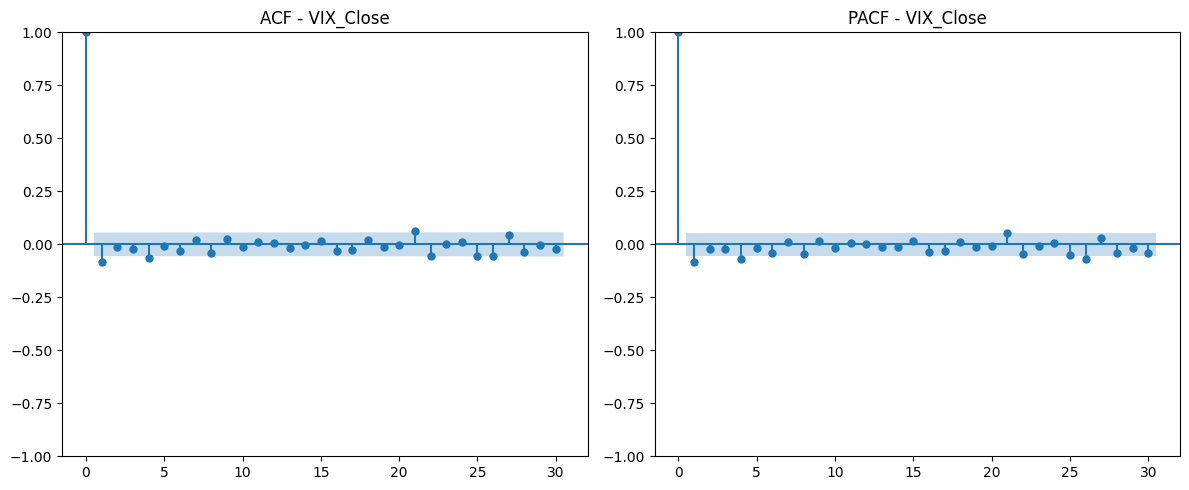

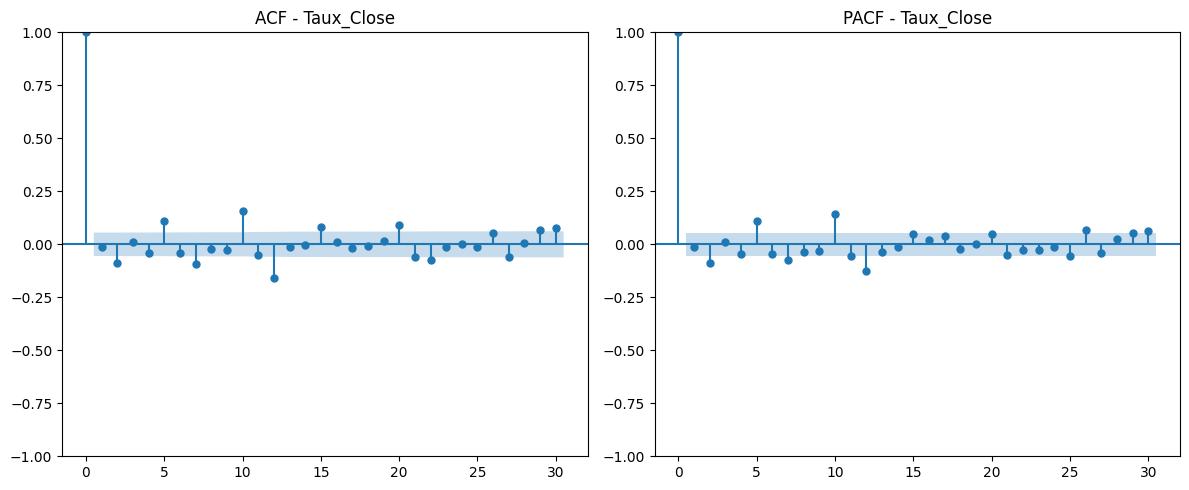

In [ ]:
# Fonction pour le test ADF
def adf_test(series, col_name):
    result = adfuller(series.dropna())
    print(f"--- Test ADF pour {col_name} ---")
    print(f"Statistique ADF : {result[0]}")
    print(f"p-value : {result[1]}")
    print(f"Valeurs critiques : {result[4]}")
    if result[1] <= 0.05:
        print("Conclusion : La série est stationnaire (p-value ≤ 0.05)")
    else:
        print("Conclusion : La série n'est pas stationnaire (p-value > 0.05)")

# Appliquer le test ADF sur chaque série
for col in log_returns.columns:
    adf_test(log_returns[col], col)

# --- Visualisation des séries log-return ---
plt.figure(figsize=(10, 6))
for col in log_returns.columns:
    plt.plot(log_returns[col], label=col)
plt.title("Séries de Rendements Logarithmiques")
plt.legend()
plt.show()

# --- Analyse des décalages temporels ---

# Visualisation des lags pour une série
for col in ['SP500_Close', 'VIX_Close', 'Taux_Close']:
    plt.figure(figsize=(12, 5))

    # Tracer l'ACF
    plt.subplot(1, 2, 1)
    plot_acf(log_returns[col].dropna(), lags=30, ax=plt.gca())
    plt.title(f"ACF - {col}")

    # Tracer la PACF
    plt.subplot(1, 2, 2)
    plot_pacf(log_returns[col].dropna(), lags=30, ax=plt.gca(), method='ywm')
    plt.title(f"PACF - {col}")

    plt.tight_layout()
    plt.show()

### <u>3 - Feature engineering</u>

#### --- Calcul des moyennes mobiles (SMA - simple et EMA - exponentielle) ---

In [ ]:
merged_data['SMA_20'] = merged_data['SP500_Close'].rolling(window=20).mean()
merged_data['SMA_50'] = merged_data['SP500_Close'].rolling(window=50).mean()
merged_data['EMA_20'] = merged_data['SP500_Close'].ewm(span=20, adjust=False).mean()
merged_data['EMA_50'] = merged_data['SP500_Close'].ewm(span=50, adjust=False).mean()

merged_data = merged_data.dropna(subset=['SMA_20', 'SMA_50'])

#### --- Calcul du RSI ---

In [ ]:
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_data['RSI_14'] = calculate_rsi(merged_data['SP500_Close'], window=14)

#### --- Calcul du MACD ---

In [ ]:
merged_data['EMA_12'] = merged_data['SP500_Close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['SP500_Close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']
merged_data['Signal_Line'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()

#### --- Visualisation des indicateurs techniques ---

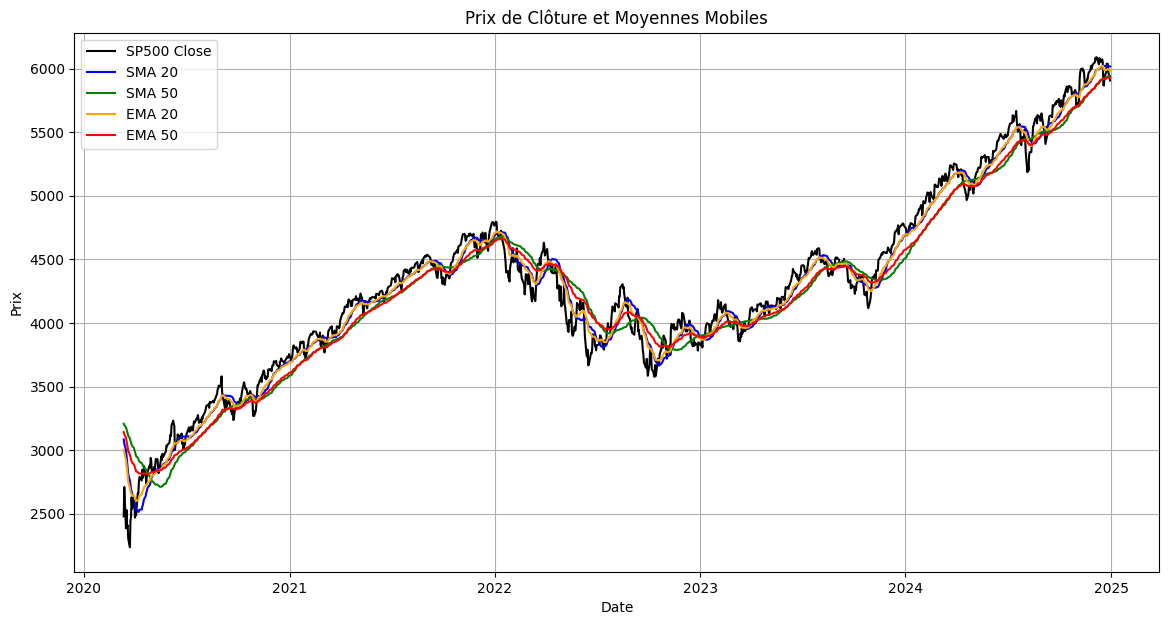

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['SP500_Close'], label='SP500 Close', color='black')
plt.plot(merged_data.index, merged_data['SMA_20'], label='SMA 20', color='blue')
plt.plot(merged_data.index, merged_data['SMA_50'], label='SMA 50', color='green')
plt.plot(merged_data.index, merged_data['EMA_20'], label='EMA 20', color='orange')
plt.plot(merged_data.index, merged_data['EMA_50'], label='EMA 50', color='red')
plt.title('Prix de Clôture et Moyennes Mobiles')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()

#### --- Analyse de la corrélation ---

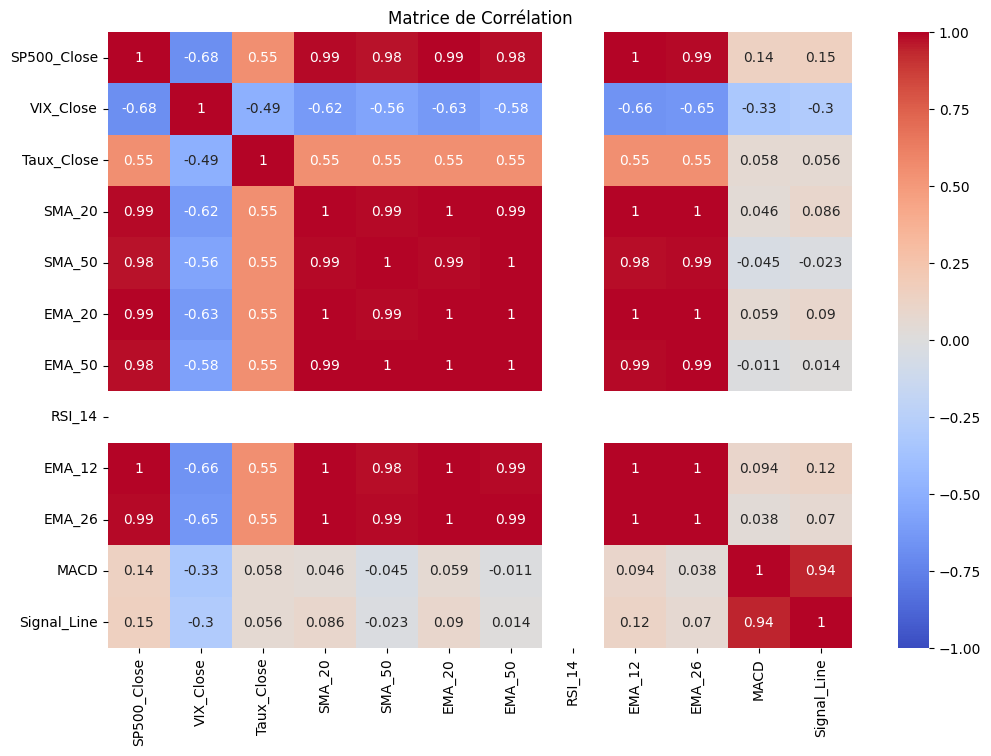

In [ ]:
correlation_matrix = merged_data.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

<h1 style='color: blue;'>Partie 2 : Développement du modèle prédictif</h1>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### <u>1 - Choix des modèles</u>

#### --- Implémentation régression linéaire ---

In [ ]:
# Normalement, 'log_returns' a déjà été défini dans les étapes précédentes
# 'log_returns' doit contenir les rendements logarithmiques calculés

# Définir X (features) et y (target)
X = log_returns.dropna().drop(columns=['SP500_Close'])  # Choisissez les colonnes pertinentes
y = log_returns['SP500_Close'].dropna()

common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Vérifiez que X et y ont la même taille
print("Longueur de X:", len(X))
print("Longueur de y:", len(y))

# Validation croisée temporelle avec rolling window
n_splits = 5  # Nombre de splits pour la validation croisée
window_size = int(len(X) * 0.8)  # 80% pour l'entraînement

# Initialiser la validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listes pour stocker les résultats
mae_list = []
rmse_list = []
accuracy_list = []

# Pour chaque split dans la validation croisée
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entraîner le modèle de régression linéaire
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    # Prédictions
    y_pred = linear_model.predict(X_test)

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_test.diff().fillna(0))
    y_pred_direction = np.sign(y_pred - y_test.shift(1)).fillna(0)
    accuracy = accuracy_score(y_direction, y_pred_direction)

    # Stockage des résultats
    mae_list.append(mae)
    rmse_list.append(rmse)
    accuracy_list.append(accuracy)

# Affichage des résultats moyens
print("Régression linéaire - résultats :")
print(f"Moyenne MAE : {np.mean(mae_list)}")
print(f"Moyenne RMSE : {np.mean(rmse_list)}")
print(f"Moyenne Accuracy : {np.mean(accuracy_list)}")

Longueur de X: 1255
Longueur de y: 1255
Régression linéaire - résultats :
Moyenne MAE : 0.005981183424921354
Moyenne RMSE : 0.008175385467461918
Moyenne Accuracy : 0.8497607655502393


#### --- Implémentation Random forest ---

In [ ]:
# Définir X (features) et y (target)
X = log_returns.dropna().drop(columns=['SP500_Close'])  # Choisissez les colonnes pertinentes
y = log_returns['SP500_Close'].dropna()

# Assurer que les indices de X et y correspondent
common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Division des données en train/test (80%/20%)
train_size = int(len(log_returns) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Validation croisée temporelle (rolling window)
n_splits = 5  # Nombre de splits pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mae_scores = []
rmse_scores = []
accuracy_scores = []

# Boucle sur les splits de validation croisée
for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialisation du modèle RandomForestRegressor
    model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))

    # Entraînement du modèle
    model.fit(X_train_fold, y_train_fold)

    # Prédictions sur le set de validation
    y_pred = model.predict(X_val_fold)

    # Calcul des métriques
    mae = mean_absolute_error(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))

    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_val_fold.diff().fillna(0))
    y_pred_direction = np.sign(y_pred - y_val_fold.shift(1)).fillna(0)
    accuracy = accuracy_score(y_direction, y_pred_direction)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    accuracy_scores.append(accuracy)

# Moyennes des métriques sur tous les splits
print("Random forest - résultats :")
print(f'Moyenne MAE : {np.mean(mae_scores)}')
print(f'Moyenne RMSE : {np.mean(rmse_scores)}')
print(f'Moyenne Accuracy : {np.mean(accuracy_scores)}')

Random forest - résultats :
Moyenne MAE : 0.007655330553866508
Moyenne RMSE : 0.010101615239671513
Moyenne Accuracy : 0.8347305389221557


<h1 style='color: blue;'>Partie 3 : Analyse des Résultats et Interprétation</h1>



1.    **Analyse des performances**

*   a. MAE (Mean Absolute Error) :
Random Forest : 0.0077  Vs
Régression Linéaire : 0.0060


La régression linéaire a une erreur absolue moyenne plus faible, ce qui signifie qu'en moyenne, ses prédictions sont plus proches des valeurs réelles par rapport à celles de la Random Forest. Cela montre que la régression linéaire est plus précise dans ce cas.

*   b. RMSE (Root Mean Squared Error) :
Random Forest : 0.0101    Vs
Régression Linéaire : 0.0082


L'erreur quadratique moyenne de la régression linéaire est également inférieure, indiquant qu'elle gère mieux les grandes erreurs (les erreurs importantes étant pénalisées davantage dans le calcul du RMSE). Cela renforce la supériorité de la régression linéaire sur la précision globale dans ce cas.


*   c. Accuracy (Précision) :
Random Forest : 83.47 %     Vs
Régression Linéaire : 84.98 %


La régression linéaire a une précision légèrement supérieure (1.51 points de pourcentage de plus) par rapport à la Random Forest, ce qui signifie qu'elle est globalement meilleure pour prédire correctement les classes ou les valeurs.







2.   **Interprétation des résultats**



*   Pour les erreurs







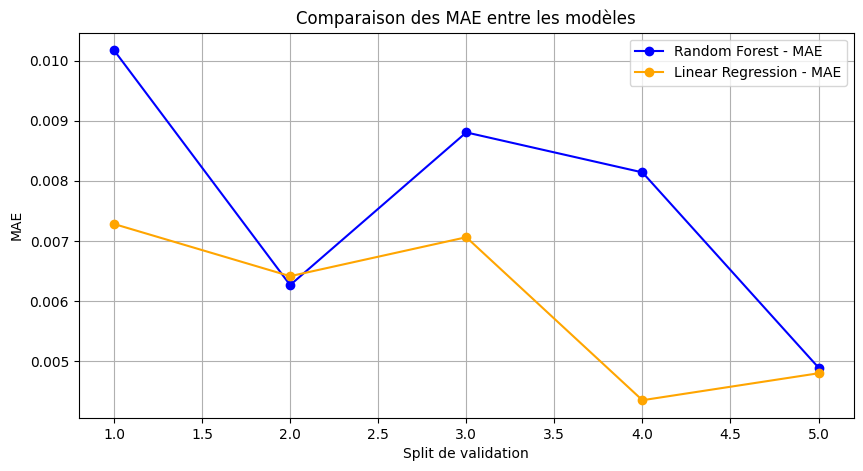

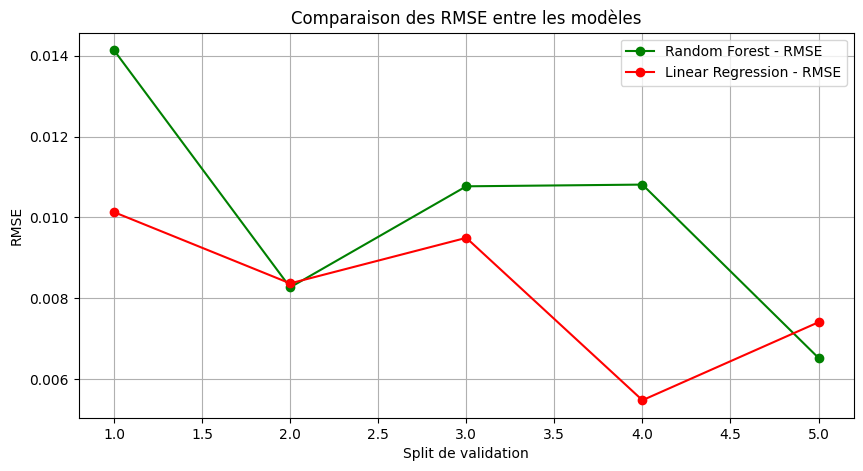

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Variables nécessaires (remplacez par vos données réelles)
splits = list(range(1, n_splits + 1))  # Numéro des splits
rf_mae = mae_scores  # MAE pour Random Forest
rf_rmse = rmse_scores  # RMSE pour Random Forest
lr_mae = mae_list  # MAE pour Régression Linéaire
lr_rmse = rmse_list  # RMSE pour Régression Linéaire

# Graphique comparatif des MAE
plt.figure(figsize=(10, 5))
plt.plot(splits, rf_mae, label='Random Forest - MAE', marker='o', color='blue')
plt.plot(splits, lr_mae, label='Linear Regression - MAE', marker='o', color='orange')
plt.title('Comparaison des MAE entre les modèles')
plt.xlabel('Split de validation')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

# Graphique comparatif des RMSE
plt.figure(figsize=(10, 5))
plt.plot(splits, rf_rmse, label='Random Forest - RMSE', marker='o', color='green')
plt.plot(splits, lr_rmse, label='Linear Regression - RMSE', marker='o', color='red')
plt.title('Comparaison des RMSE entre les modèles')
plt.xlabel('Split de validation')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()


*   Prédiction versus valeurs réelles

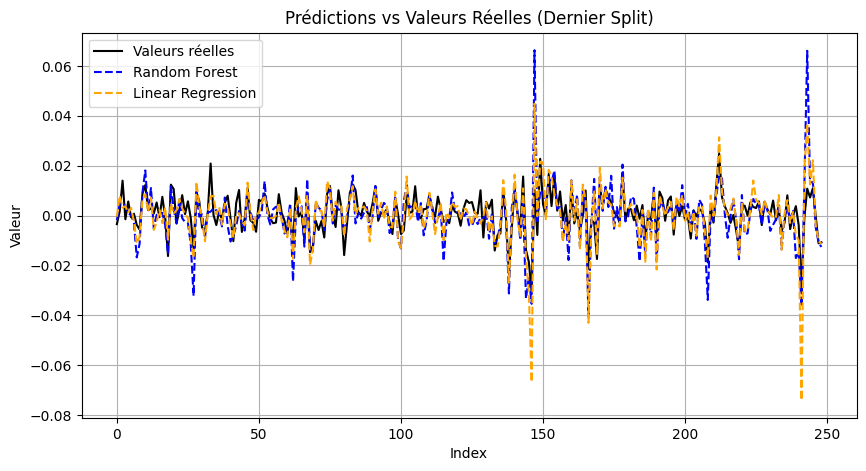

In [ ]:
split_index = -1  # Dernier split
y_true = y_test.values  # Valeurs réelles pour le dernier split
rf_predictions = model.predict(X_test)  # Prédictions Random Forest
lr_predictions = linear_model.predict(X_test)  # Prédictions Régression Linéaire

# Tracé des valeurs réelles vs prédictions
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Valeurs réelles', color='black')
plt.plot(rf_predictions, label='Random Forest', linestyle='--', color='blue')
plt.plot(lr_predictions, label='Linear Regression', linestyle='--', color='orange')
plt.title('Prédictions vs Valeurs Réelles (Dernier Split)')
plt.xlabel('Index')
plt.ylabel('Valeur')
plt.legend()
plt.grid()
plt.show()


*   Pour les erreurs cumulatives

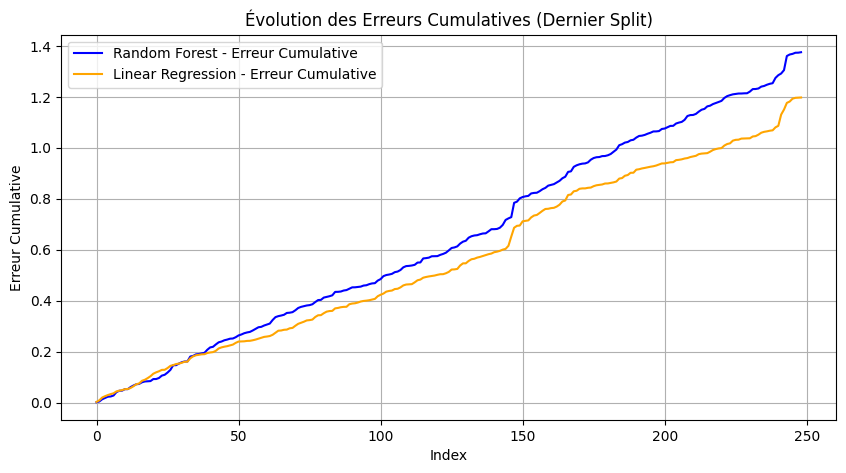

In [ ]:
# Calcul des erreurs cumulatives pour le dernier split
rf_cum_error = np.cumsum(np.abs(y_true - rf_predictions))
lr_cum_error = np.cumsum(np.abs(y_true - lr_predictions))

# Tracé des erreurs cumulatives
plt.figure(figsize=(10, 5))
plt.plot(rf_cum_error, label='Random Forest - Erreur Cumulative', color='blue')
plt.plot(lr_cum_error, label='Linear Regression - Erreur Cumulative', color='orange')
plt.title('Évolution des Erreurs Cumulatives (Dernier Split)')
plt.xlabel('Index')
plt.ylabel('Erreur Cumulative')
plt.legend()
plt.grid()
plt.show()
